# Supervised Learning II – Klassifikation mit Logistischer Regression

## Lernziele

Am Ende dieses Notebooks kannst du:

* den Unterschied zwischen Regressions- und Klassifikationsproblemen erklären,
* Klassifikationsmodelle mit Scikit-learn trainieren und bewerten,
* die logistische Regression auf geeignete Probleme anwenden und
* gängige Metriken zur Evaluation von Klassifikationsmodellen interpretieren.

# Klassifikation mit Logistischer Regression

## Einführung in die Klassifikation

Bisher haben wir uns mit **Regression** beschäftigt, also dem Vorhersagen von kontinuierlichen Größen, zum Beispiel der Fertigungsdauer in Minuten auf Basis der Maschinenanzahl. Doch in vielen praktischen Anwendungen interessiert uns nicht ein kontinuierlicher Zahlenwert, sondern eine **Zugehörigkeit zu einer Kategorie**:

* Ist ein Produkt defekt oder nicht?
* Handelt es sich bei einem Bildinhalt um eine Katze oder einen Hund?
* Wird ein Kunde den Vertrag kündigen: ja oder nein?

Solche Aufgaben zählen zum **Klassifikationsproblem**, einer eigenen Klasse des Supervised Learning. Die Zielvariable $y$ ist dabei **nicht kontinuierlich**, sondern **diskret** – oft binär (z.B. 0/1, ja/nein), oft auch mehrstufig (z.B. Klassen A, B, C).

### Beispiel: Defekte Steckverbindungen

Stellen wir uns vor, wir arbeiten in der Qualitätssicherung eines Unternehmens, das Steckverbindungen für Fahrzeuge herstellt. Bei jeder Verbindung messen wir zwei Größen:

* die **Kontaktnormalkraft** (x-Achse): wie stark wird der Stecker in die Buchse gedrückt?
* den **elektrischen Kontaktwiderstand** (y-Achse): je geringer dieser ist, desto besser leitet die Verbindung Strom.

Die Unternehmensdevise ist: Ein Kontakt mit einem Widerstand von über **300 mΩ** gilt als **defekt** und wird gewartet.

Die folgende Grafik zeigt eine Stichprobe unserer Steckverbindungen. Jede Verbindung ist entweder **defekt** (oranges Dreieck) oder **nicht defekt** (grünes Quadrat):

In [ ]:
!git clone https://github.com/wolfromanlist/MLForEngineers.git
%cd MLForEngineers/Notebooks/

from google.colab import output
output.enable_custom_widget_manager()

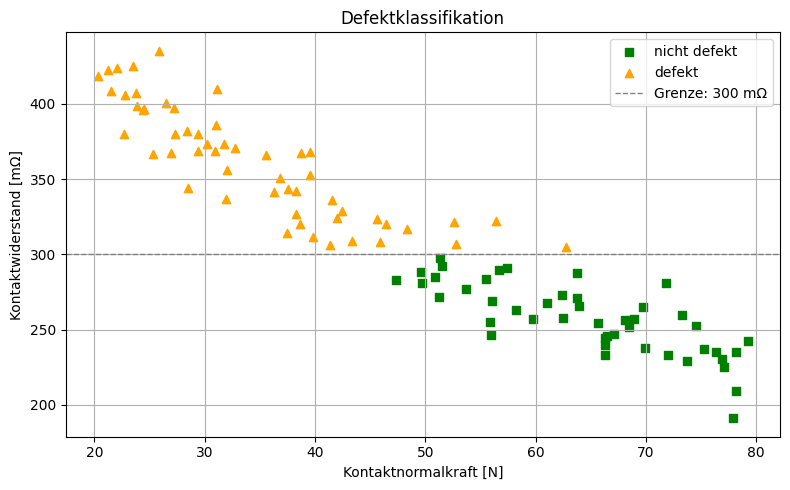

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('../Data/classification_data_resistance_force.csv')

force = data['Normalkraft']
resistance = data['Widerstand']
is_defective = resistance > 300

fig, ax = plt.subplots(figsize= (8,5))
ax.scatter(force[~is_defective], resistance[~is_defective],
            c='green', marker='s', label='nicht defekt')
ax.scatter(force[is_defective], resistance[is_defective],
            c='orange', marker='^', label='defekt')
ax.axhline(300, color='gray', linestyle='--', linewidth=1, label='Grenze: 300 mΩ')

plt.xlabel("Kontaktnormalkraft [N]")
plt.ylabel("Kontaktwiderstand [mΩ]")
plt.title("Defektklassifikation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In der Grafik ist klar zu erkennen: Defekte Verbindungen haben meist **niedrigere Kontaktnormalkräfte** und **höhere Widerstände**. Unser Ziel ist es nun, ein Modell zu bauen, das diese Regel **automatisch erlernt**, um bei zukünftigen Steckverbindungen allein anhand der Kontaktkraft schnell und zuverlässig eine Entscheidung treffen zu können: defekt oder nicht?

Wir brauchen also eine binäre Ausgabe (0 = defekt, 1 = nicht defekt) oder, noch nützlicher, eine Ausgabe, die uns sagt mit welcher Wahrscheinlichkeit ein Datenpunkt einen defekten Stecker beschreibt. Und genau hier kommt die **logistische Funktion** (oder Sigmoid-Funktion) ins Spiel.

## Zutat 1: Das logistische Modell

Der Schlüssel, um von der Regression zur (binären) Klassifikation zu gelangen, liegt in der Transformation der Eingangsdaten zu einem Wert zwischen 0 und 1, den wir als **Wahrscheinlichkeit für die Zugehörigkeit zur Klasse 1** interpretieren können. In unserem Fall definieren wir willkürlich Klasse 1 = *defekt*.

### Die Sigmoidfunktion

Um aus einem beliebigen Eingangswert $x$ eine Vorhersage zwischen 0 und 1 zu erzeugen, verwenden wir die sogenannte **Sigmoidfunktion**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
\tag{1}
$$

wobei  $z = w \cdot x + b$ einfach eine lineare Vorhersage ist. Konkret heißt das, dass wir bei der logistischen Regression einfach eine lineare Funktion als Vorhersage nehmen und dann eine nichtlineare Funktion, die Sigmoid-Funktion, darauf anwenden, um die Vorhersage auf einen Bereich zwischen 0 und 1 zu beschränken. Die Sigmoid-Funktion sieht dann so aus:

![](../Images/sigmoid.png)

Die Sigmoidfunktion (1) hat folgende Eigenschaften:

* Sie nimmt beliebige reelle Zahlen als Eingabe und gibt einen Wert im Bereich $(0, 1)$ zurück.
* Negative Werte führen zu Ausgaben nahe 0, große positive Werte zu Ausgaben nahe 1.
* Sie ist **glatt** und **differenzierbar**, was für das Training mit Gradientenverfahren (später mehr dazu) wichtig ist.

Damit ergibt sich das vollständige Modell der logistischen Regression:

$$
\hat{y} = \sigma(w \cdot x + b)
$$

Hierbei ist $\hat{y}$ die vom Modell vorhergesagte Wahrscheinlichkeit, dass die Instanz zur **positiven Klasse** gehört (z. B. *defekt*). Um daraus eine konkrete Klassenzuordnung zu treffen, kann man einen **Schwellwert** setzen (z. B. 0.5):
Wenn $\hat{y} \geq 0.5$, klassifizieren wir die Verbindung als *defekt*, andernfalls als *nicht defekt*.

### Warum heißt es eigentlich logistische „Regression“?

Obwohl die **logistische Regression** ein Modell zur **Klassifikation** ist, trägt sie den Begriff *Regression* im Namen. Mit dem Wissen über die Sigmoid-Funktion lässt sich das nun einfach rechtfertigen: Letztendlich bestimmen wir immer noch die Parameter $w$ und $b$ um einen möglichst guten "Fit" an die Daten zu erlangen. Allein die **Nutzung der logistischen Funktion** ermöglicht es uns, diese lineare Vorhersage so zu transformieren, dass sie sich **für ein Klassifikationsproblem eignet**. Dahinter steckt aber, genau wie bei der linearen Regression, eine geeignete Wahl der Modellparameter, so dass der Vorhersagefehler minimiert wird. 

Aber welcher Fehler ist das eigentlich? Können wir ebenfalls weiterhin mit der MSE-Verlustfunktion arbeiten? Genau das schauen wir uns im nächsten Abschnitt an.

## Zutat 2: Die Verlustfunktion - Von MSE zu BCE

Im obigen Beispiel haben wir zwei Klassen, *defekt* (Klasse 1) und *nicht defekt* (Klasse 0), und wollen auf Basis der Normalkraft bestimmen, ob eine Steckverbindung zur Klasse 1 oder 0 gehört. Es handelt sich hierbei um eine **binäre Klassifikation**, da wir nur zwei mögliche Klassen haben. 

Wir wissen, dass unser Modell eine Zahl zwischen 0 und 1 ausgibt, welche die Wahrscheinlichkeit darstellt, dass ein Datenpunkt zur Klasse 1 gehört. Alle $\hat{y}$ über $0.5$ werden dabei als Klasse 1 gewertet, da die Wahrscheinlichkeit größer als 50% beträgt. Je höher der Wert, desto größer die "Sicherheit" des Modells. Obwohl wir also nur einen Wert als Ausgabe bekommen, können wir zwei Sachen daraus ableiten:

1. "Ist die Vorhersage richtig oder falsch?" und
2. "Wie sicher ist sich das Modell?"

Was wir von einer geeigneten Fehlerfunktion erwarten ist klar: 
- Eine falsche Vorhersage soll einen höheren Fehler haben als eine richtige. 

Es sind aber zwei weitere Sachen wichtig:
- Eine falsche Vorhersage, die mit hoher Sicherheit getroffen wurde, soll stärker bestraft werden.
- Eine Vorhersage nahe $0.5$ soll nicht belohnt werden, da sie kaum Informationen liefert.

### Warum nicht einfach MSE?

Ein naheliegender Vorschlag ist die Verwendung des mittleren quadratischen Fehlers (MSE), den wir bereits aus der linearen Regression kennen:

$$
\mathrm{MSE} = (\hat{y} - y)^2
$$

Aber dieser Fehler misst nur den Abstand zwischen Vorhersage $\hat{y}$ und Zielwert $y$, ohne die Unsicherheit der Vorhersage sinnvoll zu berücksichtigen: Angenommen, das richtige Label sei $y = 1$. Die Vorhersage $\hat{y} = 0$, also die schlechteste Vorhersage, die überhaupt möglich ist, liefert einen MSE von $1$ - ein ziemlich niedriger Wert für eine komplett falsche Aussage. Der beste erreichbare Wert ist in diesem Problem 0, wenn $\hat{y} = y$. Je schlechter sich eine gute Vorhersage von einer schlechten unterscheiden lässt, desto schwieriger wird die numerische Minimierung der Fehlerfunktion. Am besten wäre es also, wenn der Fehler unbegrenzt ansteigen würde, je weiter man sich der falschen Klasse nähert. Der MSE ist demnach nicht gut geeignet für Klassifikation, weil er nicht die Wahrscheinlichkeit für das richtige Label berücksichtigt, sondern nur die Differenz der Zahlen.

Wir werden nun sehen, dass wir eine geeignetere Fehlerfunktion erhalten können, wenn wir sie mit dem sogenannten **Maximum-Likelihood-Ansatz** herleiten.

### Eine bessere Fehlerfunktion

#### Das Setting

Stellen wir uns vor, wir ziehen Zettel aus einer Box. Es gibt zwei Arten von Zetteln: solche mit der Zahl "0" und solche mit der Zahl "1". Das Ereignis $y = 1$ beschreibt das Ziehen einer "1", entsprechend beschreibt $y = 0$ das Ziehen einer "0". Die Wahrscheinlichkeit $p$ einen Zettel mit "1" zu ziehen ist 
$$
P(y = 1) = p = \frac{\mathrm{N_1}}{N},
$$
wobei $N_1$ die Zahl der Zettel mit "1" und $N$ die Gesamtanzahl der Zettel ist. Da wir die genauen Anzahlen nicht kennen, ist $p$ zunächst unbekannt. Andersherum ist die Wahrscheinlichkeit $q$ einen Zettel mit "0" zu ziehen
$$
P(y = 0) = q = \frac{\mathrm{N_0}}{N} = 1 - p,
$$
wobei wir genutzt haben, dass $N_0 = N - N_1$ ist.

#### Das Experiment

Jetzt ziehen wir 20 Zettel aus der Box und bekommen beispielsweise 13 mal eine "1" und 7 mal eine "0". Die Wahrscheinlichkeit für genau dieses Ergebnis berechnen wir mit:
$$
L_{13;7}(p) = p^{13} \cdot q^7 = p^{13} \cdot (1-p)^7.
$$
Wichtig: $L$ ist hier eine Funktion von $p$. Sie beschreibt die Wahrscheinlichkeit (Likelihood), mit der das beobachtete Ergebnis unter einem bestimmten $p$ auftritt. 

#### Maximum Likelihood Estimation

Der zentrale Gedanke ist jetzt:
> Wir können nun das $p$ bestimmen, das das Auftreten des beobachteten Ergebnisses (13 mal "1", 7 mal "0") am wahrscheinlichsten macht, also $L_{13;7}(p)$ maximiert.

Wir treffen also die Annahme, dass die Wahl von $p$, welches $L$ maximiert, die "wahre" Wahrscheinlichkeit am ehesten widerspiegelt. Der Grund ist: Mit jedem anderen $p$ wäre das beobachtete Ergebnis unwahrscheinlicher. Deshalb heißt das Verfahren Maximum Likelihood Estimation. Diese Schätzung ist natürlich nicht exakt richtig, aber sie verbessert sich mit wachsender Stichprobengröße.

Im folgenden Widget könnt ihr ausprobieren, welches $p$ für den obigen Fall die höchste Wahrscheinlichkeit für das beobachtete Ergebnis ergibt.

In [11]:
import numpy as np
from ipywidgets import interact, FloatSlider

def plot_likelihood(p):
    x = np.linspace(0, 1, 100)
    y = lambda x: x**13 * (1-x)**7
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(x, y(x), label=f'L = {y(p):.3g}')
    ax.axvline(p, color='red', linestyle='--', label=f'p = {p:.2f}')
    ax.set_xlabel('p')
    ax.set_ylabel('Likelihood')
    ax.legend()
    plt.show()

interact(plot_likelihood, p=FloatSlider(value=0.5, min=0, max=1, step=0.01, description='p'))

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.plot_likelihood(p)>

#### Von Maximum Likelihood zur Verlustfunktion

Das ist alles schön und gut, aber was hat es mit der logistischen Regression zu tun? Einiges, wie wir sehen werden!

##### Einmal Ziehen - Mathematisch formuliert:
Vereinfachen wir das Experiment von oben, indem wir nur _einen_ Zettel ziehen. 
Die Likelihood für ein beobachtetes Ergebnis $y$ ist:
$$
L(p) = p^y \cdot (1-p)^{1-y}
$$

<!--- Das Ereignis ist wieder $y = 1$, wenn wir einen Zettel mit "1" ziehen und $y = 0$, wenn wir einen Zettel mit "0" ziehen. Mathematisch wird dann $L$, also die Wahrscheinlichkeitsverteilung, die am wahrscheinlichsten das beobachtete Ergebnis beschreibt, zu:
-->

Beachtet, dass $L$ 
1. die **richtige Wahrscheinlichkeit** des beobachteten Ereignisses ausgibt: Wenn $y=1$, dann ist $L_{1;0} = p \cdot 1 = p$. Ziehen wir eine "0", dann gilt $L_{0;1} = 1 \cdot (1-p) = (1-p)$. 
2. eine Schätzung der **maximal wahrscheinlichen Verteilung** in Anbetracht des beobachteten Ergebnisses abgibt: Wenn wir eine "1" ziehen, ist es wahrscheinlicher, dieses Ergebnis zu erhalten, wenn $p > q$. In diesem Fall wird $L$ zu $p$. Wenn wir eine "0" ziehen, ist es wahrscheinlicher, dieses Ergebnis zu erhalten, wenn $q > p$, und in diesem Fall wird $L$ zu $q$.

##### Mehrmals ziehen - Mathematisch formuliert:
Wir haben also mit $L$ jetzt eine Schätzung der "wahrscheinlichsten" Verteilung, wenn wir _einen_ Durchlauf machen. Was ist, wenn wir $n$ Mal aus der Box ziehen mit $n$ verschiedenen Ergebnissen $y_1, y_2, ..., y_n$?
Dann multiplizieren wir die Wahrscheinlichkeiten der einzelnen (unabhängigen) Ereignisse einfach zusammen:
$$
L(p) = \prod_{i=1}^n p^{y_i} \cdot (1-p)^{1-y_i}
$$

Beispielsweise bekommen wir für den Fall unseres originalen Beispiels genau $L_{13;7} = p^{13} \cdot (1-p)^7$ raus. Macht euch das klar, falls es das nicht ist.

##### Der Bogen zur logistischen Regression:
Jetzt wird's spannend: Auch in der logistischen Regression haben wir eine Wahrscheinlichkeitsvorhersage $\hat{y}_i$ für jedes echte Label $y_i$. Wir wollen die Frage beantworten: "In Anbetracht der bekannten Labels $y_i$, was sind die Vorhersagen $\hat{y}_i$, welche die beobachteten Labels am wahrscheinlichsten machen?". Ersetzt nun $p$ durch $\hat{y}_i$ und wir erhalten:
$$
L(p) = \prod_{i=1}^n {\hat{y}_i}^{y_i} \cdot (1-\hat{y}_i)^{1-y_i}
$$

**Verschnaufpause:** \
Geschafft! Wenn ihr alles bis zu diesem Schritt nachvollziehen konntet, ist der Rest einfach. Jetzt machen wir aus der Likelihood eine Verlustfunktion. Denn bis jetzt ist die Likelihood etwas, das wir maximieren wollen. Sie misst also in gewisser Weise, wie **gut** unser Modell die Daten vorhersagt. Um das Modell zu trainieren, wollen wir wie bei der linearen Regression aber eine Verlustfunktion formulieren, die misst, wie **schlecht** das Modell die Daten vorhersagt. Ob man nun die Likelihood maximiert oder die Verlustfunktion minimiert ist letztendlich egal. Allerdings funktionieren die meisten Lösungsverfahren mit dem Prinzip der Minimierung einer Verlustfunktion, weshalb wir das hier auch so machen. 
Wie machen wir aus der Likelihood eine Verlustfunktion? Das geht in zwei Schritten:

##### Erster Schritt - Logarithmieren:
Die Likelihood $L$ ist ein Produkt aus vielen Faktoren (so viele wie Datenpunkte). Solche Produkte sind rechnerisch unpraktisch und numerisch instabil, insbesondere wenn die $\hat{y}_i$ nahe bei 0 oder 1 liegen – dann werden viele sehr kleine Zahlen miteinander multipliziert, was schnell zu Rundungsfehlern führt. Ein üblicher Trick ist daher, den Logarithmus der Likelihood zu nehmen. Der Logarithmus ist eine streng monoton steigende Funktion, d.h. das Maximum bleibt an derselben Stelle. Das Gute ist aber, dass das Produkt zu einer Summe wird:

$$
\log L = \log\left(\prod_{i=1}^n \hat{y}_i^{y_i} \cdot (1 - \hat{y}_i)^{1 - y_i}\right) = \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Diese Funktion nennt man auch die **log-Likelihood**. Je größer sie ist, desto wahrscheinlicher macht das Modell mit seinen Vorhersagen $\hat{y}_i$ die tatsächlich beobachteten Labels $y_i$.

##### Zweiter Schritt - Minimieren statt maximieren:
Da wir das Modell durch *Minimierung* einer Verlustfunktion trainieren wollen (z. B. mit Gradientenverfahren), kehren wir das Vorzeichen um:

$$
\mathcal{L} = - \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
\tag{1}
$$

Voilà! Das ist unsere neue Fehlerfunktion – sie heißt **Binary Cross-Entropy** (BCE) und ist die Standardverlustfunktion bei binären Klassifikationsproblemen. Sie bestraft falsche und gleichzeitig selbstsichere Vorhersagen besonders stark – genau das, was wir gesucht haben.

**Intuition:**

* Wenn $y_i = 1$, bleibt nur der erste Term übrig: $- \log(\hat{y}_i)$. Je näher $\hat{y}_i$ an 1, desto kleiner der Verlust. Liegt $\hat{y}_i$ nahe bei 0, wird der Verlust größer.
* Wenn $y_i = 0$, bleibt nur der zweite Term übrig: $- \log(1 - \hat{y}_i)$. Auch hier gilt: je näher $\hat{y}_i$ an 0, desto besser.

Die BCE bestraft also nicht nur falsche Vorhersagen, sondern auch falsche Vorhersagen mit hoher Sicherheit besonders stark – genau das, was wir wollen!

In [12]:
from LikelihoodWidget_Plotly import *

disp()


interactive(children=(RadioButtons(description='y₁:', index=1, options=(0, 1), value=1), RadioButtons(descript…

In [14]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, RadioButtons

def plot_loss_likelihood_two_points(y1, y2):
    yhat = np.linspace(0.001, 0.999, 500)

    def likelihood(y, yhat):
        return np.where(y == 1, yhat, 1 - yhat)

    def bce(y, yhat):
        return - (y * np.log(yhat) + (1 - y) * np.log(1 - yhat))

    # Einzelwerte
    lik1 = likelihood(y1, yhat)
    lik2 = likelihood(y2, yhat)
    total_likelihood = lik1 * lik2

    bce1 = bce(y1, yhat)
    bce2 = bce(y2, yhat)
    total_bce = (bce1 + bce2) / 2

    fig = go.Figure()

    # Linke y-Achse: BCE
    fig.add_trace(go.Scatter(x=yhat, y=total_bce, mode='lines', name='BCE (Mittel)', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=yhat, y=bce1, mode='lines', name='BCE₁', line=dict(color='blue', dash='dot')))
    fig.add_trace(go.Scatter(x=yhat, y=bce2, mode='lines', name='BCE₂', line=dict(color='blue', dash='dash')))

    # Rechte y-Achse: Likelihood
    fig.add_trace(go.Scatter(x=yhat, y=total_likelihood, mode='lines', name='Likelihood (Produkt)',
                             line=dict(color='orange'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=yhat, y=lik1, mode='lines', name='L₁',
                             line=dict(color='orange', dash='dot'), yaxis='y2'))
    fig.add_trace(go.Scatter(x=yhat, y=lik2, mode='lines', name='L₂',
                             line=dict(color='orange', dash='dash'), yaxis='y2'))

    fig.update_layout(
        title=f"BCE- und Likelihood-Kurven für zwei Datenpunkte (y₁={y1}, y₂={y2})",
        xaxis_title="ŷ (gemeinsame Vorhersage für beide Punkte)",
        yaxis=dict(title="Binary Cross-Entropy", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
        yaxis2=dict(title="Likelihood", titlefont=dict(color="orange"), tickfont=dict(color="orange"),
                    overlaying="y", side="right"),
        legend=dict(x=0.01, y=0.99),
        height=500,
        width=800,
    )

    return fig

fig = plot_loss_likelihood_two_points(1, 0)
fig.show()


## Die Minimierung des Fehlers

# Hands-On: Logistische Regression für TODO

## Inspektion

## Preprocessing

## Klassifikation

## Evaluation des Modells

### 1. Accuracy

### 2. Precision

### 3. Recall

### 4. F1

### 5. Weitere Metriken